# Inverse Kinematics using a Deep Neural Network

## Introduction:
Computing the forward kinematics of a manipulator consist on obtaining the position and orientation of the end effector wrt. the manipulator base giving only the geometry of the manipulator and the value of each joint. This is a simple task that can be solved using the well known [Denavit-Hartenberg (DH) algorithm](https://en.wikipedia.org/wiki/Denavit%E2%80%93Hartenberg_parameters). 

![forward kinematics](http://eia.udg.edu/~npalomer/imgs/robotica/forward.png)

However, the inverse kinematics consist on the oposite operation: obtaining the value of each joint knowing some manipulator paramenters and the Cartesian pose (i.e., position and orientation) of the end effector. 

![inverse kinematics](http://eia.udg.edu/~npalomer/imgs/robotica/inverse.png)


This is a much complex task than can have no solution at all, if the end effector is out of the manipulator's working space, or several solutions if the manipulator has redundancies.

There are two main approches to solve it:

* A closed form solution: through a geometric analisys of the manipular or the symbolic $^R{}T_H$ matrix, obtained  after applying the DH algorithm, it is possible to analytically obtain a cosed form solution. This is not always possible and the method must be adapted for each particular manipulator.

* An iterative solution: Iterative methods should be slower and less accurate but offer a general solution able to deal with any manipulator. These methods are normally based on the Jacobian of the  $^R{}T_H$ matrix.


The *Jacobian* matrix ($J$) is the matrix of all its first-order partial derivatives. With it we can transform the velocities in the joints into velocities in the end-effector or the other way around if we have its inverse.

However, to apply the iterative inverse kinematics algorithm, this $J$ matrix must be computed at each configuration and then inverted, which is computationally expensive. 

![Jacobian](http://eia.udg.edu/~npalomer/imgs/robotica/jacobian.png)

## Approach:

In this project we propose an iterative solution that instead of being based on the $J$, uses a deep neural network to approximate it. 

The methodology that we follow is divided in 3 steps:

* Using the forward kinematcs equation generate a dataset.
* Use the dataset to train a Deep Neural Network model.
* Test the trained model to see how accurate it is.
* Implement and iterative algorithm that makes use of this model to solve the inverse kinematics problem.

## Nano IK DNN Project

The project we have prepare is very simple and can be executed in a Jetson Nano board or any other computer with the necessary modules installed. It only conly contains a Jupyter Notebook called `ik_dnn_project.ipynb` and a `utils.py` file with some necessary functions and classes. To download it use `git` to clone it:

```bash
git clone ....
```

You need `pytorch` to run it, therefore, you can install it or if you are in a Jetson Nano just use the base docker image.

Once everything is ready, open the `ik_dnn_project.ipynb` using Jupyter lab or another IDE anf follow the following steps.

## Database generation

The `ik_dnn_project.ipynb` makes use of a *class* named `DH` that uses the Denavit-Hartenberg (DH) parameters to compute the end effector pose of a manipulator. For more information about the DH parameters you can check the [wikipedia](https://en.wikipedia.org/wiki/Denavit%E2%80%93Hartenberg_parameters). 

![](http://eia.udg.edu/~npalomer/imgs/robotica/DH_params.png)

Additionally, the `DH` class allows us to plot the current robot configuration using the `matplotlib` module. If it is not installed in your system, by default it is not installed in the Jetson Nano base Docker images, you can add it using `pip`:

```bash
pip install matplotlib
```

In [19]:
import numpy as np
from utils import DH

Two manipulator are define here: a simple *Theta-theta* manipulator with 2 DoFs and a SCARA manipulator with 4 DoF. Choose the one you want by commenting/uncommenting the appropiated lines of code. More complex manipulators can be defined but the size of the database and therefore the learning time increases explonentially with the number of DoFs.

With the *theta-theta* you can generate the dataset, train the DNN model and test it with less than 10 minutes in a Jetson Nano 2GB.

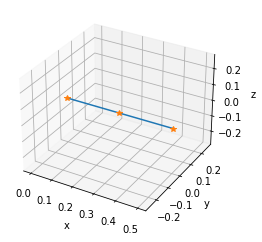

In [20]:
def load_theta_theta():
    robot = DH(2, "theta-theta", np.array([True, True, False, False, False, False]))
    robot.set_dof(0, 0, 0, 0.25, 0, True)
    robot.set_dof(1, 0, 0, 0.25, np.pi/2, True)
    robot.set_limits(0, -np.radians(135), np.radians(135))
    robot.set_limits(1, -np.radians(135), np.radians(135))
    return robot

def load_SCARA():
    robot = DH(4, "SCARA", np.array([True, True, True, False, False, True]))
    robot.set_dof(0, 0, 0, 0.323, 0, True)
    robot.set_dof(1, 0, -0.2, 0.38, 0, True)
    robot.set_dof(2, 0, 0.24, 0, 0, False)
    robot.set_dof(3, np.pi/2, 0.01, 0, 0, True)
    robot.set_limits(0, -np.radians(180), np.radians(180))
    robot.set_limits(1, -np.radians(150), np.radians(150))
    robot.set_limits(2, 0.01, 0.20)
    robot.set_limits(3, -np.radians(360), np.radians(360))
    return robot

robot = load_theta_theta() 
# robot = load_SCARA()

robot.plot()

The dataset we are going to build includes the folloging elements:

$$
(q_{init},~ee\_pose_{inc}) \rightarrow q_{inc} 
$$

where $q_{init}$ is the manipulator curren configuration (i.e., value for each joint), $ee\_pose_{inc}$ is the Cartesian increment for the end effector, and $ q_{inc}$ is a configuration increment that, starting from $q_{init}$, moves the end effector $ee\_pose_{inc}$. With the forward kinematcis, what we can do is to compute two different configurations (i.e., $q_{init}$ and $q_{final}$), compute is Cartesian position (i.e., $ee\_pose_{init}$ and $ee\_pose_{final}$) and then substract $ee\_pose_{final}$ - $ee\_pose_{init}$ to obtain $ee\_pose_{inc}$ and $q_{final}$ - $q_{init}$ to obtain $q_{inc}$.

Thre methods have been implemented to create the random $q_{init}$ and $q_{final}$ configurations, compose the batchs computing the end effector and configuration increment and finally composing the whole dataset.

In [21]:
def get_random_q(robot, batch_size, max_inc=0.2):
    """Get 2 random configurations inside the robot limits at a max_inc distance"""
    q_init = np.random.rand(batch_size, robot.n_dof)
    q_init = q_init * (robot.limits[:,1] - robot.limits[:,0]) + robot.limits[:,0]
    q_inc = (np.random.rand(batch_size, robot.n_dof) * 2 - 1) * max_inc
    q_final = np.clip(q_init + q_inc, robot.limits[:,0], robot.limits[:,1])
    return q_init, q_final        

In [22]:
def get_batch(robot, batch_size):
    """ Create a batch (q_init + euclidean_velocity) --> (configuration_velocity)"""
    q_init, q_final = get_random_q(robot, batch_size)
    ee_pose_init = np.zeros((batch_size, robot.ee_dof))
    ee_pose_final = np.zeros((batch_size, robot.ee_dof))
    for j, init in enumerate(q_init):
        robot.set_joints(init)
        ee_pose_init[j] = robot.get_TE_pose()[robot.ee_mask]
    for j, final in enumerate(q_final):
        robot.set_joints(final)
        ee_pose_final[j] = robot.get_TE_pose()[robot.ee_mask]
        
    return np.hstack((q_init, ee_pose_final - ee_pose_init)), q_final - q_init

In [23]:
def get_dataset(robot, batch_size, num_batchs):
    xt = np.empty((num_batchs, batch_size, robot.ee_dof + robot.n_dof))
    yt = np.empty((num_batchs, batch_size, robot.n_dof))
    for i in range(num_batchs):
        x, y = get_batch(robot, batch_size)
        xt[i] = x
        yt[i] = y
        if (i+1)%int(num_batchs/10) == 0:
            print("{}%".format(((i+1)/num_batchs)*100))
    return xt, yt

In [24]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
x, y = get_dataset(robot, 128, 2000) # Thetha-theta
# x, y = get_dataset(robot, 256, 5000) # SCARA
x_t = torch.tensor(x).float().to(device)
y_t = torch.tensor(y).float().to(device)

Device: cuda:0
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%


## Training

To train the DNN model we are going to use a standard neural network with 3 fully connected layers. We have tested several models and this one was working fine! You can play with the `layer_size` if you want to optimize more the model.

In [25]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

layer_size = 100 # Theta-theta
# layer_size = 300 # SCARA


class Net(nn.Module):
    def __init__(self, robot):
        super().__init__()
        self.fc1 = nn.Linear(robot.n_dof + robot.ee_dof, layer_size)
        self.fc2 = nn.Linear(layer_size, layer_size)
        self.fc3 = nn.Linear(layer_size, robot.n_dof)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

The training loop is also very standard. It uses the $q_{init}$ and the desired $ee\_pose_{inc}$ as input an compares the output of the model with the known $q_{inc}$. A loss function computes the error between both that is then backpropagated.

In [26]:
def train_model(xt, yt, epochs, net, optimizer):
    net.train()
    loss_log = []
    for epoch in range(epochs):
        running_loss = 0.0
        
        for x, y in zip(xt, yt):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = net(x)
                loss = criterion(outputs, y)
                
                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

                # statistics
                running_loss += loss.item() * x_t.size(0) 
        print('[%d, %5d] loss: %.3f' % (epoch + 1, len(x_t), running_loss / len(x_t) ))
        loss_log.append(running_loss / len(x_t))
    print('Finished Training')
    return loss_log

The *loss* criterion used has been the `MSELoss` while the optimizer used has been the `Adam` optimizer with a $lr=0.001$.

In [27]:
net = Net(robot)
net.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Trainable parameters: ", params)

Trainable parameters:  10802


To train the network it is only required to call the `train_model` function with the required parameters. For the *theta-theta* manipulator trainning for 20 epochs is more than enough to obtain good results. However, for more complex manipulator these values have to be increased.

In [32]:
log = train_model(x_t, y_t, 20, net, optimizer) # Theta-theta
# log = train_model(x_t, y_t, 100, net, optimizer) # SCARA

[1,  2000] loss: 1.056
[2,  2000] loss: 1.043
[3,  2000] loss: 1.033
[4,  2000] loss: 1.024
[5,  2000] loss: 1.014
[6,  2000] loss: 1.002
[7,  2000] loss: 0.994
[8,  2000] loss: 0.986
[9,  2000] loss: 0.977
[10,  2000] loss: 0.972
[11,  2000] loss: 0.964
[12,  2000] loss: 0.956
[13,  2000] loss: 0.949
[14,  2000] loss: 0.944
[15,  2000] loss: 0.938
[16,  2000] loss: 0.933
[17,  2000] loss: 0.930
[18,  2000] loss: 0.923
[19,  2000] loss: 0.918
[20,  2000] loss: 0.912
Finished Training


## Testing

Just to verify that the model has been corectly trained we will generate some more random batches and using the trainned model we will evaluate the average and maximum error obtained.

In [33]:
def evaluate(robot, net, device, N=5000):
    error = np.zeros((N, robot.ee_dof))
    net.eval()
    for i in range(N):
        x, y = get_batch(robot, 1)
        x_t = torch.tensor(x).float().to(device)
        out = net(x_t)
        y = y.flatten()
        y_out = out[0].cpu().detach().numpy()
        robot.set_joints(y_out)
        ee_net = robot.get_TE_pose()
        robot.set_joints(y)
        ee_in = robot.get_TE_pose()
        err_i = np.abs(ee_net[robot.ee_mask] - ee_in[robot.ee_mask])
        error[i] = err_i
    return error

In [34]:
error = evaluate(robot, net, device)
print("Average abs error: ", np.mean(error, axis=0))
print("Max error: ", np.max(error, axis=0))

Average abs error:  [0.00031362 0.00184706]
Max error:  [0.00444361 0.01464039]


## Iterative IK algorithm

A very basic Inverse kinematics algorithm has been implemented here. Normally, it will require to calculate the *Jacobian* at the current robot configuration and then calcukate its inverse, or just transpose it to obtain an approximation of the inverse. However, here we have replaced the *Jacobian* by the DNN that we have just trainned. 

In [35]:
def inverse_kinematics(robot, Eg, inc_p=0.01):
    max_error = 0.01
    max_iterations = 10000
    Ei = robot.get_TE_pose()
    
    # Apply disabled axis
    Eg = robot.ee_mask * Eg
    Ei = robot.ee_mask * Ei

    i = 0
    trajectory = []
    while np.linalg.norm(Eg - Ei) > max_error and i < max_iterations:
        qi = robot.get_joints_value()
        # print("qi: ", qi)
        trajectory.append(qi)
        inc_E = inc_p * (Eg - Ei)/np.linalg.norm(Eg - Ei)
        # print("inc_E: ", inc_E)
        x = np.hstack((qi, inc_E[robot.ee_mask]))
        xt = torch.tensor(x).float().to(device)
        inc_q = net(xt).cpu().detach().numpy()
        # print("inc_q: ", inc_q)
        
        # Avoid large increments
        inc_q = inc_p *  (inc_q / np.max(np.abs(inc_q)))
     
        robot.set_joints(qi + inc_q)
        Ei = robot.get_TE_pose()
        # print("Ei: ", Ei)
        
        # Remove disabled axis
        Ei = robot.ee_mask * Ei
        i += 1
    
    if i >= max_iterations:
        print("No solution found!")
        return None
    if len(trajectory) == 0:
        qi = robot.get_joints_value()
        trajectory.append(qi)
    print("Solution found after {} iterations".format(i))
    return np.array(trajectory)

Solution found after 183 iterations
Final configuration:  [-1.16606544  1.75846492]
Position reached:  [ 0.30584368 -0.09021379]


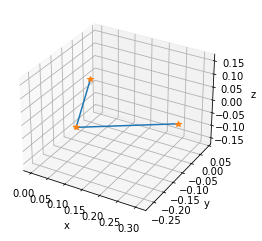

In [37]:
# Set initial configuration
robot.set_joints(np.zeros(robot.n_dof))
# define desired ee pose
e_g = np.array([0.3, -0.1, -0.05, 0.0, 0.0, 0]) # Theta-theta
# e_g = np.array([0.32, 0.43, 0.00, 0, 0, 0.85]) # SCARA
q_traj = inverse_kinematics(robot, e_g)
print("Final configuration: ", q_traj[-1])
robot.set_joints(q_traj[-1])
print("Position reached: ", robot.get_TE_pose()[robot.ee_mask])
robot.plot()

## Save/Load model

You can save or load a previously saved model to avoid having to train every time!

In [38]:
# Save the model
weights_path = "ik_dnn_weights/" + robot.name + "_IK.weights"
torch.save(net.state_dict(), weights_path)

In [16]:
# Load the model
weights_path = "ik_dnn_weights/" + robot.name + "_IK.weights"
print(weights_path)
net.load_state_dict(torch.load(weights_path, map_location=device))

ik_dnn_weights/SCARA_IK.weights


<All keys matched successfully>